# Phys 581 Winter 2019
# Assignment #5: Multiprocessing
## Alexander Hickey, 10169582

Note that this notebook makes use of the Keras deep learning library for python, which is compatible only with Python 2.7-3.6.

In [7]:
#Must be running Python 3.6 or lower!
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

In [14]:
#Import useful libraries
import time
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import sys, os
import signal, subprocess
import psutil
from keras.models import Model, Sequential
from keras.layers import Input, Dense
%matplotlib inline

### Introduction

Parallel computing allows one to harness the processing power of a multi-core computer, and can significantly decrease the time required for repetitive computations. The idea behind parallel computing is to take a large problem and divide it into smaller ones which can be solved simultaneously, and allocate these different tasks to different parts of the CPU network. Often times, it is very powerful to implement parallel computing in the framework of scientific computations, to allow researchers to execute code and analyze output within a reasonable timeframe.

In [3]:
print( psutil.cpu_stats(), '\n' )
print( psutil.cpu_times(), '\n' )
print( psutil.cpu_times_percent(interval=1, percpu=False), '\n' )
print( 'number of physical(?) CPUs: ', psutil.cpu_count(), '\n' )
print( psutil.cpu_times_percent(interval=1, percpu=True), '\n' )
print(sys.argv)

scpustats(ctx_switches=24129603, interrupts=11695840, soft_interrupts=12423381, syscalls=0) 

scputimes(user=809.53, nice=76.48, system=247.38, idle=731319.77, iowait=1231.12, irq=0.0, softirq=7.24, steal=0.0, guest=0.0, guest_nice=0.0) 

scputimes(user=3.5, nice=0.0, system=1.0, idle=95.5, iowait=0.0, irq=0.0, softirq=0.0, steal=0.0, guest=0.0, guest_nice=0.0) 

number of physical(?) CPUs:  4 

[scputimes(user=8.3, nice=0.0, system=4.6, idle=87.0, iowait=0.0, irq=0.0, softirq=0.0, steal=0.0, guest=0.0, guest_nice=0.0), scputimes(user=2.9, nice=0.0, system=4.8, idle=89.5, iowait=2.9, irq=0.0, softirq=0.0, steal=0.0, guest=0.0, guest_nice=0.0), scputimes(user=4.7, nice=0.0, system=5.6, idle=89.7, iowait=0.0, irq=0.0, softirq=0.0, steal=0.0, guest=0.0, guest_nice=0.0), scputimes(user=7.3, nice=0.0, system=5.5, idle=87.2, iowait=0.0, irq=0.0, softirq=0.0, steal=0.0, guest=0.0, guest_nice=0.0)] 

['/home/alexander.hickey/anaconda3/envs/Python36/lib/python3.6/site-packages/ipykernel_launche

In [3]:
def cpu_idle(nloop=999):
    """ simple example of signal handling
    """
    cpu_idle.flag = nloop
    
    def handler(signum, frame):
        print('Signal handler called with signal ',signum)
        #signal.alarm(0)
        cpu_idle.flag = 0
        
    signal.signal(signal.SIGINT, handler)

    while cpu_idle.flag > 0:
        cpu_idle.flag -= 1
        cpu = psutil.cpu_times_percent(interval=1, percpu=True)
        print('\t'.join([str(c.idle) for c in cpu]))

In [4]:
# make a simple CPU intensive task
#
cmnd = '[i**2 for i in range(9876543)]'
%timeit exec(cmnd)

2.33 s ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# spawn a subprocess to execute the task
#
status = subprocess.check_output('python -c "[i**2 for i in range(9876)]; print(True)"',shell=True)
print('subprocess status: ', status)

subprocess status:  b'True\n'


In [6]:
cmnd = 'python -c "[i**2 for i in range(9876543)]; print(True)"'
import time
def paralize(cmdlist, nwait=100, nicer=False):
    
    plist = []
    for n, cmd in enumerate(cmdlist):
        plist.append( subprocess.Popen(cmnd, shell=True) ) 
    
    tlist = {}
    n0 = time.time()
    for i in range(nwait):
        
        time.sleep(0.1)
        
        for n,p in enumerate(plist):    
            try:
                parent = psutil.Process(pid=p.pid)
        
                child = parent.children()[0]
                
                if child is None:# or len(child)< 1:
                    continue
                proc = psutil.Process(pid=child.pid)
                
                cputime = proc.cpu_times().user
                
                tlist[p.pid] = [time.time()-n0,cputime]
        
            except:
                None
                
        
    return tlist
        
dat = paralize([cmnd for j in range(8)])

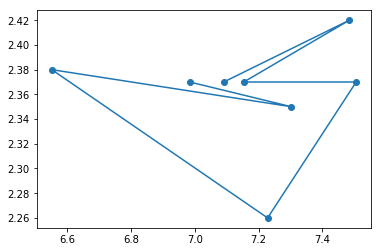

In [7]:
t =[]
for key in dat:
    t.append(dat[key])
t = np.array(t)

plt.plot(t[:,0],t[:,1],marker= 'o')

In [8]:
np.sum(t[:,1])/np.mean(t[:,0])

2.637225121698413

In [9]:
# run three subprocesses in parallel
#
paralize([cmnd for i in range(3)], nwait=500)

{24038: [3.275688409805298, 2.33],
 24040: [3.1598305702209473, 2.35],
 24042: [2.791616916656494, 2.31]}

In [10]:
# run one process for each CPU
#
paralize([cmnd for i in range(8)], nwait=10)

{24148: [2.1016995906829834, 1.04],
 24150: [2.1153082847595215, 0.86],
 24151: [2.1210849285125732, 0.93],
 24154: [2.1265604496002197, 0.8],
 24156: [2.1604132652282715, 0.98],
 24158: [2.1660420894622803, 0.96],
 24159: [2.191803455352783, 0.94],
 24162: [2.1994588375091553, 1.0]}

In [11]:
# oversubscribing by 50% takes slightly longer
#
paralize([cmnd for i in range(12)], nwait=10)

{24164: [4.687588214874268, 0.83],
 24166: [4.714017391204834, 0.85],
 24168: [4.752850770950317, 0.85],
 24170: [4.779255151748657, 0.81],
 24172: [4.829874277114868, 0.84],
 24174: [4.869801044464111, 0.79],
 24176: [4.896193027496338, 0.87],
 24178: [4.918595790863037, 0.89],
 24180: [4.965177297592163, 0.89],
 24182: [5.001089811325073, 0.85],
 24184: [5.031454801559448, 0.85],
 24185: [5.064440965652466, 0.91]}

In [12]:
paralize([cmnd for i in range(24)], nwait=15)

{24188: [38.2697274684906, 0.75],
 24189: [38.27644729614258, 0.56],
 24190: [38.28322649002075, 0.68],
 24194: [38.28898334503174, 0.56],
 24195: [38.29474139213562, 0.58],
 24196: [36.56262397766113, 2.32],
 24199: [34.60294198989868, 2.3],
 24201: [37.037755489349365, 2.27],
 24203: [38.31720280647278, 0.7],
 24205: [38.3228702545166, 0.63],
 24208: [35.14685416221619, 2.34],
 24209: [38.33403944969177, 2.01],
 24211: [38.33968472480774, 0.76],
 24213: [36.6871132850647, 2.02],
 24215: [1.584768295288086, 0.12],
 24217: [38.35640072822571, 0.61],
 24219: [38.362064361572266, 0.65],
 24222: [36.73503494262695, 2.3],
 24223: [36.325801610946655, 2.37],
 24225: [38.37921667098999, 0.63],
 24227: [38.38493037223816, 0.91],
 24229: [34.3840069770813, 2.32],
 24231: [37.180442094802856, 2.43],
 24233: [37.44187879562378, 2.3]}

### Task: determine scaling efficiency
Gather estimates of computation as a function of number of processes, plot, and analyze.

Ideally we would have a perfectly linear relationship up to the number of CPUs and constant thereafter.  In practice the slope will be less than one and may saturate earlier.

In [13]:
cmdlist = [cmnd for j in range(5)]
for n, cmd in enumerate(cmdlist):
    print(n,cmd)

0 python -c "[i**2 for i in range(9876543)]; print(True)"
1 python -c "[i**2 for i in range(9876543)]; print(True)"
2 python -c "[i**2 for i in range(9876543)]; print(True)"
3 python -c "[i**2 for i in range(9876543)]; print(True)"
4 python -c "[i**2 for i in range(9876543)]; print(True)"


In [14]:
cmnd = 'python -c "[i**2 for i in range(9876543)]; print(True)"'

def time_par(cmdlist, time_res = 1e-5):
    '''
    This function will compute both the ...    
    Args:
        cmdlist: List of commands to track
        time_res: Time step between tracking
        
    Return:
        tlist: Array of both wall and cpu times for each process
               to terminate. Axis 0 corresponds to wall time,
               axis 1 corresponds to cpu time.
    
    '''
    plist = [subprocess.Popen(cmnd, shell=True) for j in cmdlist]
    ch_list = [0.0] 
    t0 = time.time()
    t_dict = {p.pid:0.0 for p in plist}
    
    
    while ch_list != []:
        
        ch_list = []
        time.sleep(time_res)
        
        for p in plist:    
            
            parent = psutil.Process(pid=p.pid)
            child = parent.children()
            
            try:
                proc = psutil.Process(pid=child[0].pid)
                cputime = proc.cpu_times().user
                t_dict[p.pid] = [time.time()-t0,cputime]
                ch_list.append(child)
                
            except:
                None
    
    t = np.array([t_dict[key] for key in t_dict ])
    
    return t

def ratio(t):
    
    
    return np.mean(t[:,1])/np.max(t[:,0])


    
t=time_par([cmnd for j in range(2)])
t

array([0., 0.])

In [15]:
2.315/2.47

0.9372469635627529

In [16]:
N = 7
t_rat = []

for k in range(2,N+1):
    
    t = time_par([cmnd for j in range(k)])
    
    t_rat.append(ratio(t))
 

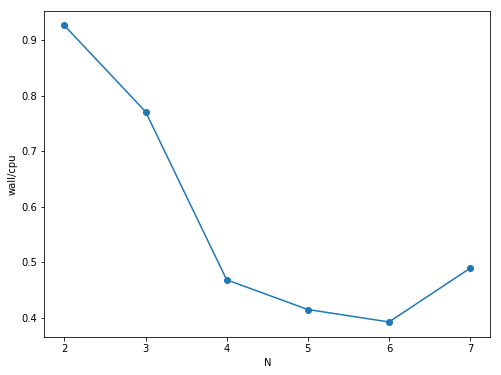

In [17]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,N+1),t_rat,marker= 'o')
plt.xlabel('N')
plt.ylabel('wall/cpu')

plt.show()

### Task: Use the multiprocessing package to speed up hyperparameter optimization.    

In [19]:
from multiprocessing import Pool
import timeit

def f(x,y):
    #print(y)
    
    return time.sleep(.001)

if __name__ == '__main__':
    for j in range(1,7):
        
        with Pool(j) as p:
            %timeit p.map(f, [(1,3), (2,3)])

TypeError: f() missing 1 required positional argument: 'y'

In [61]:
def create_model(nodes=[8,11,6]):
    '''
    This function creates a dense Keras model with connectivity:
    3-nodes-3 where nodes represents the "deep" layers.
    
    Args:
        nodes: List describing number of deep layers and number of nodes at
               each layer. 
        
    Return:
        model: Dense Keras model with desired connectivity.
    
    '''
    #Create model
    model = Sequential()
    
    #Define input layer
    model.add(Dense(nodes[0], input_dim=3, activation='relu'))
    
    #Define "deep" layers
    for n in nodes[1:]:
        
        model.add(Dense(n, activation='relu'))
    
    #Define output layer
    model.add(Dense(3, activation='linear')) #sigmoid'))

    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model,xyz,epochs = 999,L=900,ndt=99):
    '''
    This function trains a given Keras model to shift a time series
    forward by some timestep ndt.
    
    Args:
        model: Keras model
        ndt: Timestep to shift time series
        xyz: 3D time series data
        L: Length of training interval
        epochs: Number of epochs to perform training
        
    Return:
        model: Trained model
    
    '''
    
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=epochs, batch_size=100, 
                        verbose=0)
    
    return model

def mean_square(args):
    '''
    args = (nodes,epochs,xyz)
    
    '''
    
    vs, ndt, L = 5000, 99, 900
    nodes,epochs,xyz = args
    mod = create_model(nodes = nodes)
    mod = train_model(mod,xyz,epochs = epochs)
    
    return np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:]-mod.predict(xyz[vs:vs+L]) )**2))

NCPU = psutil.cpu_count()

In [62]:
def dfunc(state, t0, sigma=10.0, beta=8/3.0, rho=58.0):
    '''
    This returns the time derivative of the coordinates,
    defined by the 3D Lorenz system:
    dx/dt = sigma*(y-x)
    dy/dt = x*(rho-z)-y
    dz/dt = x*y-beta*z
    
    Args:
        state: array of length 3, coordinates at time t0
        t0: Time
        sigma, beta, rho: Lorentz system parameters
        
    Return:
        d/dt state: array, Time derivative of coordinates
    
    '''
    
    #Unpack state vector
    x, y, z = state
    
    return np.array([ sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

#Define time interval of interest
t0, tf, tstep = 0.0, 20.0, 9999
tvals = np.linspace(t0, tf, tstep)

#Set initial state set to [1,1,1]
xyz_0 = np.ones(3)

#Integrate Lorenz system over time interval
xyz = scipy.integrate.odeint( dfunc, xyz_0, tvals )

In [65]:
num_layers = [[5,8,5],[5,8,8,5],[5,8,8,8,5],[5,8,8,8,8,5],[5,8,8,8,8,8,5]]
epochs = 999
n_lay = [[num_layers[j],epochs,xyz] for j in range(len(num_layers))]

if __name__ == '__main__':
    with Pool(NCPU) as p:
        m_square = p.map(mean_square, n_lay)

[4.569310457814799, 4.983071838340053, 4.27387804341402, 5.17026945532112, 4.218257772388161]


## Parallel python
https://www.parallelpython.com/  

### Figure out how to get this working on a single computer 

In [20]:
psutil.cpu_count()

4

### Figure out how to get this working on all of the ST026 computers 

### Conclusion